In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, auc, roc_curve
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, accuracy_score, roc_auc_score
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, VotingClassifier
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings("ignore")

Import the training dataset and inspect the column headers

In [2]:
train = pd.read_csv('invoice_train.csv', low_memory=False)
train_clients = pd.read_csv('client_train.csv', low_memory=False)

print(train.columns)
print('\n')
print(train_clients.columns)

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')


Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')


Both datasets are linked by the header "client_id" and classes of fraud are the header "target".
A useful analysis is to get a look at the count for each class

Number of Fraudless CLients:  127927  Or  94.4 % of the data
Number of Fraud Clients:  7566  Or  5.6 % of the data


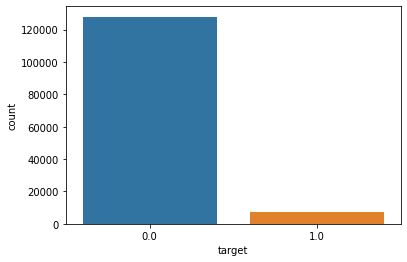

In [3]:
sns.countplot(train_clients['target'], label="Count")

L, F = train_clients['target'].value_counts()
print('Number of Fraudless CLients: ', L, ' Or ', round(L/(L+F)*100,1), '% of the data')
print('Number of Fraud Clients: ', F, ' Or ', round(F/(L+F)*100,1), '% of the data')

As expected the commited fraud class is much smaller than the fraudless class. This data is imbalanced
and may need weighting, oversampling, and/or undersampling when being modelled

The training data has some coulmns that need to be wrangled to have more useful data to model. 
Inline comments explain what was done

In [3]:
def wrangle1(df):

    #convert header "invoice_date" to datetime and sort data
    df["invoice_date"] = pd.to_datetime(df["invoice_date"])
    df.sort_values(['client_id', 'invoice_date'], ascending=[True, True], inplace=True)

    #map "counter_type"
    d={"ELEC":0,"GAZ":1}
    df['counter_type'] = df['counter_type'].map(d)

    #individually "new_index" and "old_index" will not provide much information
    #however the change in index values will. 
    #so that there is no bias between readings between clients the 
    #index_change was normalized between -1 & 1
    df['index_change'] = df['new_index']-df['old_index']
    copy = df.copy()
    copy['index_change'] = copy['index_change'].abs()
    frac = copy.groupby(['client_id'])['index_change'].transform('max')
    frac.replace(0, 1e-40, inplace=True)
    df['index_change'] = df['index_change']/frac
    del copy

    #map unique "counter_statue"
    dic = {'0':0, '1':1, '2':2, '269375':3, '3':4, '4':5 ,'420':6,
         '46':7, '5':8, '618':9, '769':10, 'A':11}
    df['counter_statue'] = df['counter_statue'].map(dic)

    #timedelta between index readings may differ between those who 
    #do and do not commit fraud
    diff_dates = df['invoice_date'].diff(periods=1)
    diff_dates.iloc[0] = pd.Timedelta("0 days")
    
    diff_dates = (diff_dates/np.timedelta64(1, 'D')).astype(int)
    diff_dates.loc[diff_dates<0] = 0
    df['diff_dates'] = diff_dates
    
    return df

train = wrangle1(train)

Now that the data has been wrangled. Determining what values to use for the model is important.
The data must be grouped by clients so using simple statictics to get single values is necessary.
Since there are many different forms of fraud that can be commited, multiple statistical 
techniques are used.

1. The number of transactions may show if fraud clients have more or less transactions than fraudless
2. The mean value for each four levels of consumption is useful 
3. The standard deviation of the counter_coefficient, counter_number, and counter_statue
   will show if big/small changes occured
4. The maximum values for the tarif_type and reading_remarks indicate unfavorable behaviour
5. The mean change in index values may show if index values have been tampered with
6. The median difference in transaction dates could indicated transaction behaviour

Along with these obtained values a look at the client catagory, district, and region are also 
useful indicators

In [4]:
def wrangle2(df, ndf):

    dat_fr = (df.groupby('client_id').size().reset_index(name='ntransactions'))

    aggs = {}

    aggs['consommation_level_1'] = ['mean']

    aggs['consommation_level_2'] = ['mean']

    aggs['consommation_level_3'] = ['mean']

    aggs['consommation_level_4'] = ['mean']

    aggs['counter_coefficient'] = lambda x: np.std(x)

    aggs['tarif_type'] = ['max']

    aggs['index_change'] = ['mean']

    aggs['counter_number'] = lambda x: np.std(x)

    aggs['reading_remarque'] = ['max']

    aggs['counter_statue'] = lambda x: np.std(x)

    aggs['diff_dates'] = ['median']


    sel_data = df.groupby(['client_id']).agg(aggs)

    sel_data.columns = ['_'.join(col).strip() for col in sel_data.columns.values]

    sel_data.reset_index(inplace=True)

    sel_data = pd.merge(dat_fr, sel_data, on='client_id', how='left')

    merged = pd.merge(ndf,sel_data, on='client_id', how='left')
    
    return merged

X = wrangle2(train, train_clients)

X = X.drop(['client_id', 'creation_date', 'target'], axis=1)

y = train_clients["target"].values

Now that values are obtained for possible indicators, they can be checked to see how well they correlate 
with the fraud/fraudless classes

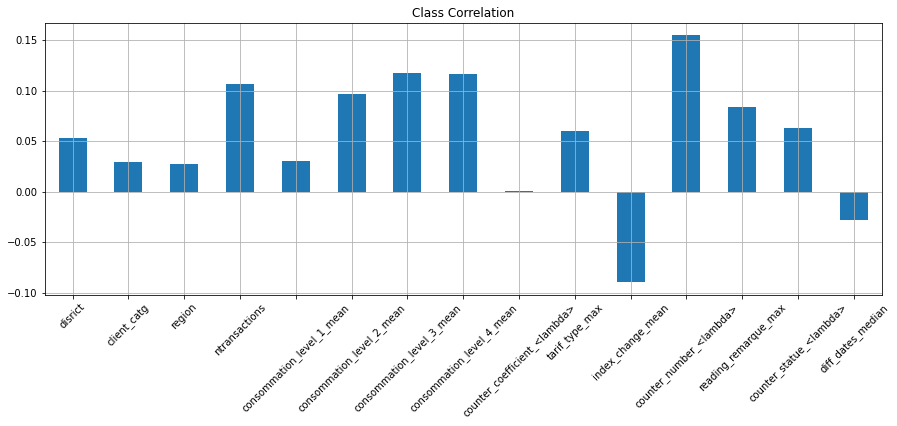

In [5]:
X.corrwith(train_clients.target, method='kendall').plot.bar(
        figsize=(15, 5), title="Class Correlation", fontsize=10,
        rot=45, grid=True)
plt.show()

This plot shows that the std of the counter number has the highest postive correlation 
and the mean change in the index the highest negative correlation. 

The lowest correlations, diff_dates_median and counter_coefficient_lambda, should be dropped

Single plots of the distributions of some of these correlations for each class also shows visual variance between fraud and fraudless clients

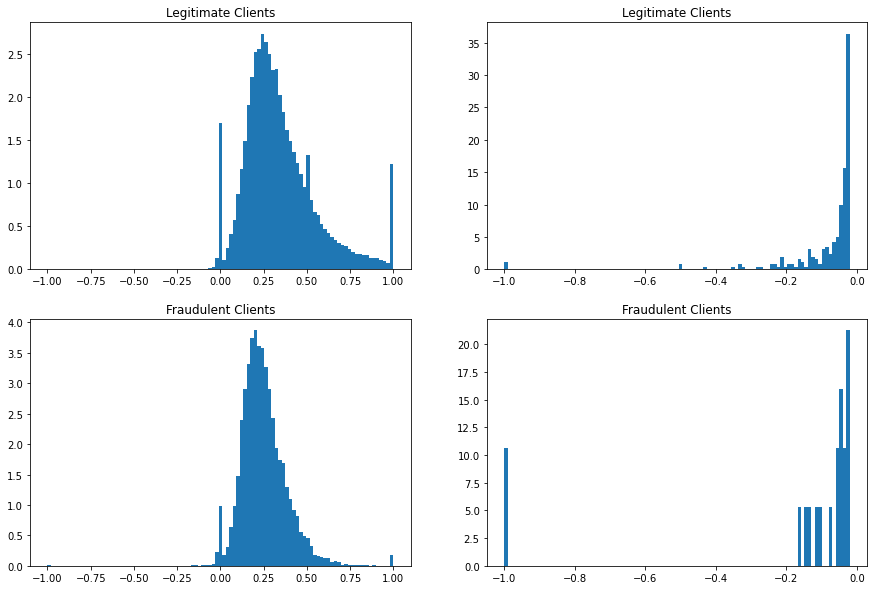

In [87]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
X.loc[train_clients["target"] == 0]["index_change_mean"].hist(bins=np.linspace(-1,1,100), ax=ax[0,0], density=1, grid=False)
X.loc[train_clients["target"] == 1]["index_change_mean"].hist(bins=np.linspace(-1,1,100), ax=ax[1,0], density=1, grid=False)
ax[0,0].title.set_text("Legitimate Clients")
ax[1,0].title.set_text("Fraudulent Clients")
X.loc[train_clients["target"] == 0]["index_change_mean"].hist(bins=np.linspace(-1,-0.02,100), ax=ax[0,1], density=1, grid=False)
X.loc[train_clients["target"] == 1]["index_change_mean"].hist(bins=np.linspace(-1,-0.02,100), ax=ax[1,1], density=1, grid=False)
ax[0,1].title.set_text("Legitimate Clients")
ax[1,1].title.set_text("Fraudulent Clients")
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

The mean change in the index shows that fraud clients tend to have lower values, however this may also 
be due the smaller sample size of the class. But a zoomed in look at the negative values shows that 
more fraud clients have values here.

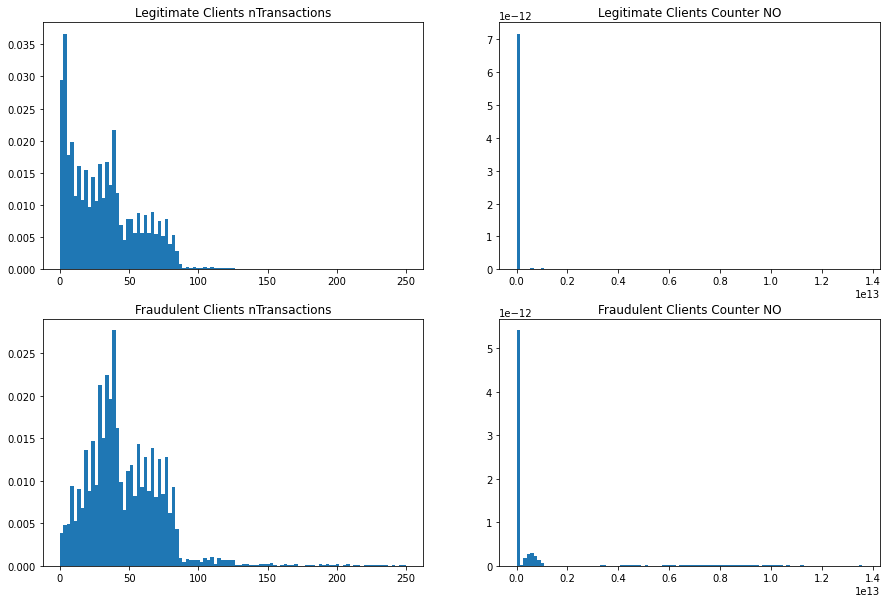

In [88]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
X.loc[train_clients["target"] == 0]["ntransactions"].hist(bins=np.linspace(0,250,100), ax=ax[0,0], density=1, grid=False)
X.loc[train_clients["target"] == 1]["ntransactions"].hist(bins=np.linspace(0,250,100), ax=ax[1,0], density=1, grid=False)
ax[0,0].title.set_text("Legitimate Clients nTransactions")
ax[1,0].title.set_text("Fraudulent Clients nTransactions")
X.loc[train_clients["target"] == 0]["counter_number_<lambda>"].hist(bins=100, ax=ax[0,1], density=1, grid=False)
X.loc[train_clients["target"] == 1]["counter_number_<lambda>"].hist(bins=100, ax=ax[1,1], density=1, grid=False)
ax[0,1].title.set_text("Legitimate Clients Counter NO")
ax[1,1].title.set_text("Fraudulent Clients Counter NO")
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

Clients who commited fraud seem to have more transactions and their std of counter numbers vary a lot more

In [5]:
X_df = X.drop(['counter_coefficient_<lambda>', 'diff_dates_median'], axis=1)

Now that the indicators have been selected the data is standardized 
and principal component analysis can render a 2D look of the data

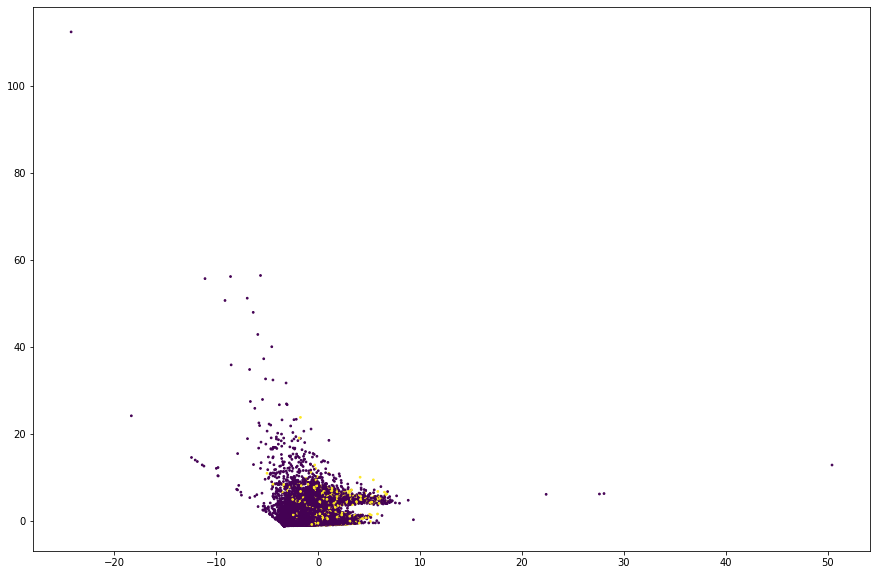

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X_df)

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

fig = plt.figure(figsize=(15,10))
plt.scatter(X2D[:,0],X2D[:,1], s=3, c=y)
plt.show()

From the PCA plot we can see that the classes are clumped and difficult to visually distinguish 
unique regions for each class. This is indicative that a simple linear model may not work well
for this data but rather more complex models should be used. 
However, there are some outliers in the data that may affect the fit negatively. It was decided to keep these outliers as some fraud data is part of the outliers and may prove to be beneficial in the long run.

Before testing models, let's take a quick look at the null accuracy score(eg: what happens if a model just predicts everything as one class, since this data is highly imbalanced this score will be high)

In [7]:
print('Null accuracy: %.3f' % np.maximum(np.mean(y), 1 - np.mean(y)))

Null accuracy: 0.944


As expected this value corresponds to the count percentage of fraudless clients. With models, accuracy may drop however, being able to classify fraud clients as well should take priority. 

Models using default paramaters have been selected and cross validated with multiple metrics to test their performance

In [112]:
models = []
models.append(('LogR', LogisticRegression()))
models.append(('ET', ExtraTreesClassifier()))
models.append(('XGB', xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LGBM', LGBMClassifier()))

estimators = [('ET', ExtraTreesClassifier()), ('LGBM', LGBMClassifier())]
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
models.append(('Stacking', StackingClassifier(estimators, final_estimator=xgb_model)))

estimators.append(('XGB', xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)))
models.append(('Vote Hard', VotingClassifier(estimators, voting='hard')))
models.append(('Vote Soft', VotingClassifier(estimators, voting='soft')))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
for name, model in models:              
    scores = cross_validate(model, X, y, scoring=('roc_auc', 'balanced_accuracy',
                                             'f1', 'jaccard'), cv=cv) 
              
    print('Tested Model: ' + name)
    print('Mean ROC AUC: %.3f' % np.mean(scores['test_roc_auc']))
    print('Mean Balanced Accuracy: %.3f' % np.mean(scores['test_balanced_accuracy']))
    print('Mean F1: %.3f' % np.mean(scores['test_f1']))
    print('Mean Jaccard: %.3f' % np.mean(scores['test_jaccard']))
    print('\n')

Tested Model: LogR
Mean ROC AUC: 0.744
Mean Balanced Accuracy: 0.512
Mean F1: 0.048
Mean Jaccard: 0.025


Tested Model: ET
Mean ROC AUC: 0.801
Mean Balanced Accuracy: 0.553
Mean F1: 0.185
Mean Jaccard: 0.102


Tested Model: XGB
Mean ROC AUC: 0.827
Mean Balanced Accuracy: 0.563
Mean F1: 0.213
Mean Jaccard: 0.119


Tested Model: KNN
Mean ROC AUC: 0.672
Mean Balanced Accuracy: 0.559
Mean F1: 0.197
Mean Jaccard: 0.110


Tested Model: LGBM
Mean ROC AUC: 0.833
Mean Balanced Accuracy: 0.556
Mean F1: 0.195
Mean Jaccard: 0.108


Tested Model: Stacking
Mean ROC AUC: 0.827
Mean Balanced Accuracy: 0.554
Mean F1: 0.190
Mean Jaccard: 0.105


Tested Model: Vote Hard
Mean ROC AUC: nan
Mean Balanced Accuracy: nan
Mean F1: nan
Mean Jaccard: nan


Tested Model: Vote Soft
Mean ROC AUC: 0.831
Mean Balanced Accuracy: 0.555
Mean F1: 0.192
Mean Jaccard: 0.107




As expected the decision tree based (ET, XGB, and LGBM) models worked better. These models were not hyperparameterised, however the XGB model was selected based on overall better scores

The XGB model can now be hyperparameterised to find the best fitting paramaters for the data with the Jaccard similarity score used for the scoring

In [173]:
def xgboost_search(X, y):
    params = {
        'eta':[0.1,0.3,0.5,0.7],
        'base_score':[0.2,0.5,0.7],
        'max_depth':[5,6,7,8,10]
        }
    
    xgbclass = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)
    grid_search = GridSearchCV(estimator=xgbclass, param_grid=params, scoring='jaccard', n_jobs=1, cv=skf.split(X,y))
    grid_search.fit(X, y)
    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest Jaccard Similarity Score: %.3f" % grid_search.best_score_)

xgboost_search(X,y)

Best estimator: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
Parameters:  {'base_score': 0.5, 'eta': 0.3, 'max_depth': 6}
Highest Jaccard Similarity Score: 0.119


Coincidentally all the tested params' best values are the same as the xgb defaults!

Since the data is so imbalanced we can test whether weighting, oversampling, 
or undersampling can help with better fitting the XGB model.

In [174]:
def cross_val(model, X_dat, y_dat, cv, name):
    
    scores = cross_validate(model, X_dat, y_dat, scoring=('roc_auc', 'balanced_accuracy',
                                             'f1', 'jaccard'), cv=cv) 
              
    print('Tested Method: ' + name)
    print('Mean ROC AUC: %.3f' % np.mean(scores['test_roc_auc']))
    print('Mean Balanced Accuracy: %.3f' % np.mean(scores['test_balanced_accuracy']))
    print('Mean F1: %.3f' % np.mean(scores['test_f1']))
    print('Mean Jaccard: %.3f' % np.mean(scores['test_jaccard']))
    print('\n')


oversample = BorderlineSMOTE(k_neighbors=3)
X_ov, y_ov = oversample.fit_resample(X, y)

combined = SMOTETomek(smote=BorderlineSMOTE(k_neighbors=3))
X_cb, y_cb = oversample.fit_resample(X, y)

counter = Counter(y)
weight = counter[0]/counter[1]

model1 = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", 
                           use_label_encoder=False)

model2 = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", 
                           use_label_encoder=False, scale_pos_weight=weight)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

cross_val(model1, X_ov, y_ov, cv, 'BordelineSMOTE')
cross_val(model1, X_cb, y_cb, cv, 'SMOTETomek')
cross_val(model2, X, y, cv, 'Weighted')

Tested Method: BordelineSMOTE
Mean ROC AUC: 0.987
Mean Balanced Accuracy: 0.951
Mean F1: 0.951
Mean Jaccard: 0.906


Tested Method: SMOTETomek
Mean ROC AUC: 0.987
Mean Balanced Accuracy: 0.951
Mean F1: 0.950
Mean Jaccard: 0.905


Tested Method: Weighted
Mean ROC AUC: 0.816
Mean Balanced Accuracy: 0.727
Mean F1: 0.276
Mean Jaccard: 0.160




The oversampling and undersampling performed better than weighting and also performed better than the null accuracy score. However, the BorderlineSMOTE method performed best and was selected

Next we can test the accuracy when the data is split into a train-test dataset

Tested Method: XGB with BorderlineSMOTE
Accuracy Score: 0.927
Matthews Correlation Coeff: 0.293
Cohen Kappa Score: 0.293
Roc Auc Score: 0.644
Confusion Matrix: 
[[0.90842534 0.03572061]
 [0.03766901 0.01818504]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     31982
         1.0       0.34      0.33      0.33      1892

    accuracy                           0.93     33874
   macro avg       0.65      0.64      0.65     33874
weighted avg       0.93      0.93      0.93     33874





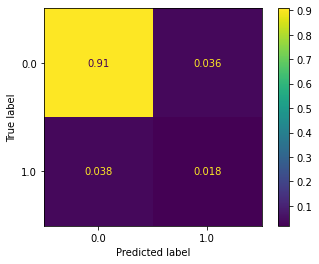

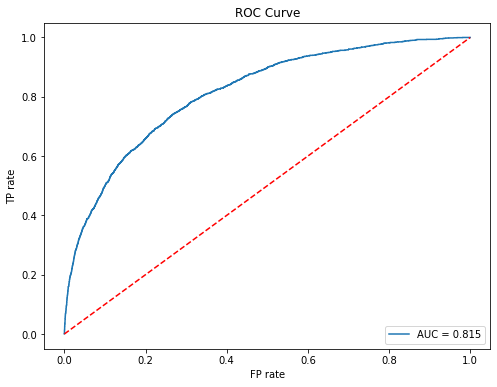

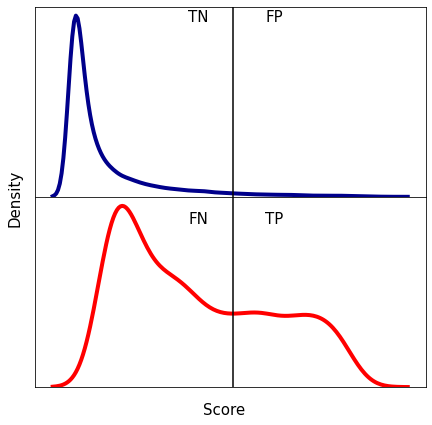

In [9]:
def model_test(model, X_tr, y_tr, X_tst, y_tst, name):
    
    Z_cls = model.fit(X_tr, y_tr)
    y_cv = model.predict(X_tst)
    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
    #y_cv = cross_val_predict(Z_cls, X_tst, y_tst, cv=cv)
    
    y_proba = model.predict_proba(X_tst)[:,1]
    
    print('Tested Method: ' + name)
    print('Accuracy Score: %.3f' % accuracy_score(y_tst, y_cv))
    print('Matthews Correlation Coeff: %.3f' % matthews_corrcoef(y_tst, y_cv))
    print('Cohen Kappa Score: %.3f' % cohen_kappa_score(y_tst, y_cv))
    print('Roc Auc Score: %.3f' % roc_auc_score(y_tst, y_cv))
    print('Confusion Matrix: ')
    print(confusion_matrix(y_tst, y_cv, normalize='all'))
    print('Classification Report: ')
    print(classification_report(y_tst, y_cv))
    print('\n')
    plot_confusion_matrix(model, X_tst, y_tst, normalize='all') 
    plt.show()
    
    fp_r, tp_r, t = roc_curve(y_test, y_proba)
    auc_val = auc(fp_r, tp_r)
    plt.figure(figsize=(8,6))
    plt.plot(fp_r, tp_r, label="AUC = %.3f" % auc_val)
    plt.plot([0,1],[0,1],"r--")
    plt.ylabel("TP rate")
    plt.xlabel("FP rate")
    plt.legend(loc=4)
    plt.title("ROC Curve")
    plt.show()
    
    fig, ax = plt.subplots(2, figsize=(7,7))
    fig.subplots_adjust(hspace=0)
    sns.distplot(y_proba[y_tst==0.0], hist=False, kde=True, 
             bins=180, color = 'darkblue',
             kde_kws={'linewidth': 4}, ax=ax[0])
    sns.distplot(y_proba[y_tst==1.0], hist=False, kde=True, 
             bins=180, color = 'red',
             kde_kws={'linewidth': 4}, ax=ax[1])
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    ax[0].axvline(0.5, 0, 10, color='k')
    ax[1].axvline(0.5, 0, 10, color='k')
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    fig.text(0.5, 0.07, 'Score', ha='center', fontsize=15)
    fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)
    fig.text(0.45, 0.85, 'TN', ha='center', fontsize=15)
    fig.text(0.60, 0.85, 'FP', ha='center', fontsize=15)
    fig.text(0.45, 0.45, 'FN', ha='center', fontsize=15)
    fig.text(0.60, 0.45, 'TP', ha='center', fontsize=15)
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), y.astype(np.float32), 
                                                    stratify=y, test_size=0.25, random_state=150)


oversample = BorderlineSMOTE(k_neighbors=3)
X_train_cb, y_train_cb = oversample.fit_resample(X_train, y_train)


model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model_test(model, X_train_cb, y_train_cb, X_test, y_test, 'XGB with BorderlineSMOTE')


So about 66% of the fraud is coming back as false negatives and 4% of fraudless as false positives.
Also the percentage of true positives to false postives is 33% true postive fraud and 66% false positives. 
This is reflected in the metric scores with the fraud class substantially affecting the MCC and Kappa scores.
However the AUC score of 0.815 means that it is still a useful result.

It is evident that this is a difficult dataset with multiple forms of fraud occuring and few clear lines
where fraud is easy to distingish. This leads to an issue where decreasing false negatives can increase 
false postives and vice versus.

In a real world setting it is up to the client in this situation to decide whether to optimze for less false positives(so fraudless clients are not further investigated for fraud) or for less false negatives(where more fraudulent clients are found but will have more false postives as well to investigate)

For this test case a balance between false negatives and false postives was chosen.

Another model that has not been tested is a neural network. Below is an optimized implementation of a pytorch nn-model

In [10]:
def torch_nn(X_tr, y_tr, X_tst): 
    
    class_weights = class_weight.compute_class_weight('balanced',np.unique(y_tr),y_tr)
    class_weights = torch.tensor(class_weights,dtype=torch.float)

    def BCELoss_class_weighted(pred, target, weights):

        pred = torch.clamp(pred,min=1e-7,max=1-1e-7)
        loss = weights[1] * (target * torch.log(pred)) + \
               weights[0] * ((1 - target) * torch.log(1 - pred))

        return torch.neg(torch.mean(loss))

    y_tr = y_tr[:, np.newaxis]

    x_tr = Variable(torch.from_numpy(X_tr))
    y_tr = Variable(torch.from_numpy(y_tr))


    net = torch.nn.Sequential(
          torch.nn.Linear(13, 234),
          torch.nn.PReLU(init=0.1), 
          torch.nn.Linear(234, 156),
          torch.nn.PReLU(init=0.1), 
          torch.nn.Linear(156, 52),
          torch.nn.PReLU(init=0.1),
          torch.nn.Linear(52, 1),
          torch.nn.Sigmoid())


    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
    loss_func = torch.nn.BCELoss() 

    
    BATCH_SIZE = 750
    EPOCH = 30

    torch_dataset = Data.TensorDataset(x_tr, y_tr)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, num_workers=1)


    for epoch in range(EPOCH):
    
        for step, (batch_x, batch_y) in enumerate(loader): 
        
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)

            prediction = net(b_x)     # input x and predict based on x

            loss = loss_func(prediction, b_y)
            #loss = BCELoss_class_weighted(prediction, b_y, class_weights)
      
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
    
        if ((epoch+1)/EPOCH*100)%10==0:
            print(str(int((epoch+1)/EPOCH*100))+'% completed')

    x_tst = Variable(torch.from_numpy(X_tst))

    predicted = net(x_tst)
    predictions = np.squeeze(predicted.data.numpy())
    
    return predictions

Let's test the pytoch nn-model

10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed


Accuracy Score: 0.931
Matthews Correlation Coeff: 0.307
Cohen Kappa Score: 0.306
Roc Auc Score: 0.644
Confusion Matrix: 
[[0.91314873 0.03099723]
 [0.03790518 0.01794887]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     31982
         1.0       0.37      0.32      0.34      1892

    accuracy                           0.93     33874
   macro avg       0.66      0.64      0.65     33874
weighted avg       0.93      0.93      0.93     33874



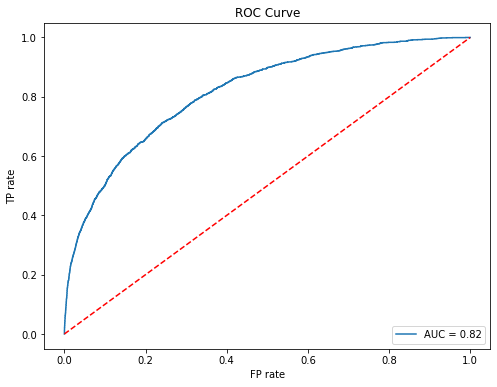

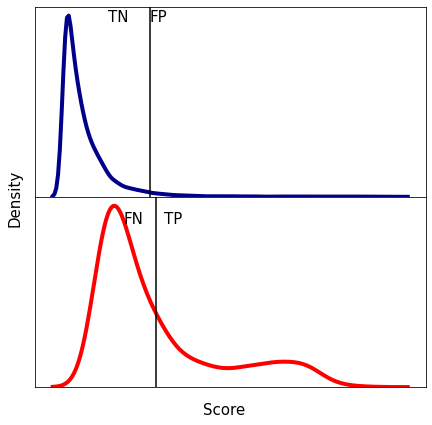

In [19]:
predictions = torch_nn(X_train, y_train, X_test)

y_proba = predictions.copy()
predictions[predictions<=0.20] = 0.0
predictions[predictions>0.20] = 1.0

print('\n')
print('Accuracy Score: %.3f' % accuracy_score(y_test, predictions))
print('Matthews Correlation Coeff: %.3f' % matthews_corrcoef(y_test, predictions))
print('Cohen Kappa Score: %.3f' % cohen_kappa_score(y_test, predictions))
print('Roc Auc Score: %.3f' % roc_auc_score(y_test, predictions))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, predictions, normalize='all'))
print('Classification Report: ')
print(classification_report(y_test, predictions))

fp_r, tp_r, t = roc_curve(y_test, y_proba)
auc_val = auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc_val)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

fig, ax = plt.subplots(2, figsize=(7,7))
fig.subplots_adjust(hspace=0)
sns.distplot(y_proba[y_test==0.0], hist=False, kde=True, 
            bins=180, color = 'darkblue',
            kde_kws={'linewidth': 4}, ax=ax[0])
sns.distplot(y_proba[y_test==1.0], hist=False, kde=True, 
            bins=180, color = 'red',
            kde_kws={'linewidth': 4}, ax=ax[1])
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].axvline(0.2, 0, 10, color='k')
ax[1].axvline(0.2, 0, 10, color='k')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
fig.text(0.5, 0.07, 'Score', ha='center', fontsize=15)
fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)
fig.text(0.29, 0.85, 'TN', ha='center', fontsize=15)
fig.text(0.37, 0.85, 'FP', ha='center', fontsize=15)
fig.text(0.32, 0.45, 'FN', ha='center', fontsize=15)
fig.text(0.40, 0.45, 'TP', ha='center', fontsize=15)
plt.show()

The pytorch nn-model performed about as well as the xgb model with similar false negatives and false postives. It performed better without oversampling and weighting. However, both oversampling and weighting did identify more true positives/fraud at the expense of a lot more false positives and therefore the model without these two methods was selected.

Since the xgb and pytorch nn-model performed similarily well, both models will be used to predict the classes for the test data and cooberate whether their results have similar correlations to the training data

In [8]:
test = pd.read_csv('invoice_test.csv', low_memory=False)
test_clients = pd.read_csv('client_test.csv', low_memory=False)

test['counter_statue'] = test['counter_statue'].astype(str)
test = wrangle1(test)
X_pred = wrangle2(test, test_clients)

X_pred_df = X_pred.drop(['client_id', 'creation_date', 'counter_coefficient_<lambda>','diff_dates_median'], axis=1)

scaler = StandardScaler()
X_pred = scaler.fit_transform(X_pred_df)

oversample = BorderlineSMOTE(k_neighbors=3)
X_cb, y_cb = oversample.fit_resample(X, y)


Lets take a look at the distributions of the data between the training and test datasets

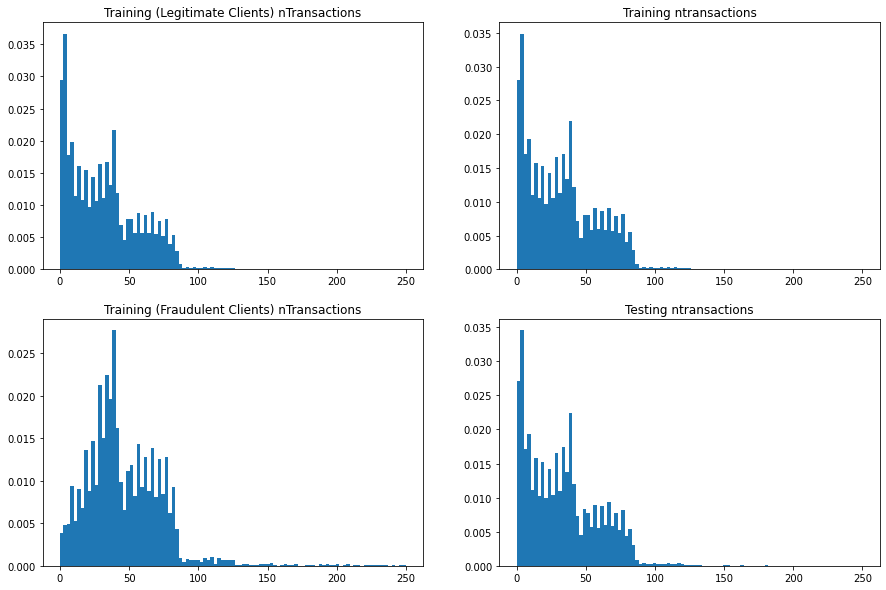

In [35]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
X_df.loc[train_clients["target"] == 0]["ntransactions"].hist(bins=np.linspace(0,250,100), ax=ax[0,0], density=1, grid=False)
X_df.loc[train_clients["target"] == 1]["ntransactions"].hist(bins=np.linspace(0,250,100), ax=ax[1,0], density=1, grid=False)
ax[0,0].title.set_text("Training (Legitimate Clients) nTransactions")
ax[1,0].title.set_text("Training (Fraudulent Clients) nTransactions")
X_df["ntransactions"].hist(bins=np.linspace(0,250,100), ax=ax[0,1], density=1, grid=False)
X_pred_df["ntransactions"].hist(bins=np.linspace(0,250,100), ax=ax[1,1], density=1, grid=False)
ax[0,1].title.set_text("Training ntransactions")
ax[1,1].title.set_text("Testing ntransactions")
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

The distributions show that the training and testing datasets are similar. This indicates that a similiar ratio of fraud to fraudless clients should be expected when modelling. 

**Note** other plots of variables have also been looked at and have similar distributions between training and testing data. However, only one plot comparisson was done to save space in the notebook. 

Since the distributions are similar between the test and train datasets,  cross correlations for both datasets should have similar correlations as well when the test classes have been predicted.

Number of Fraudless CLients:  51665  Or  89.0 % of the data
Number of Fraud Clients:  6404  Or  11.0 % of the data


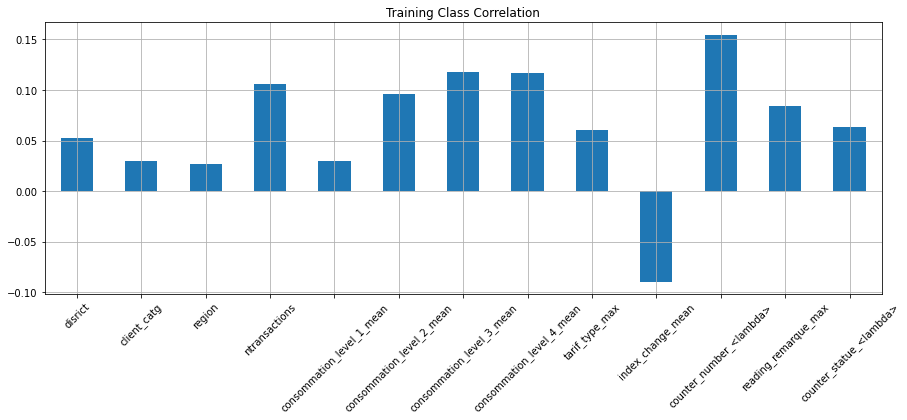

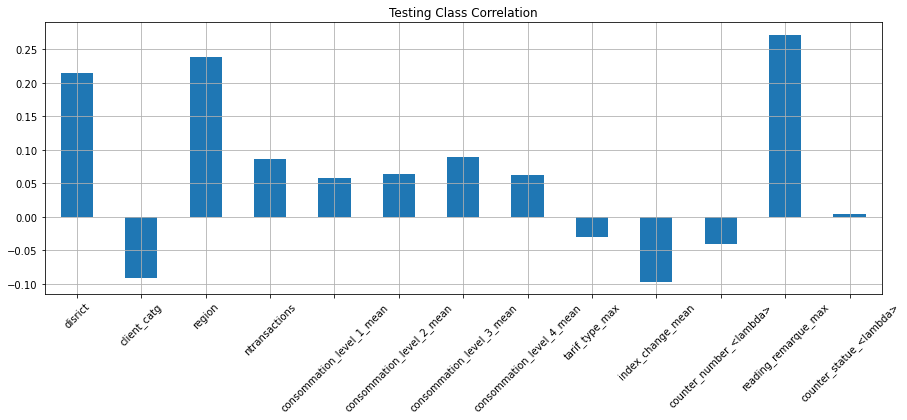

In [11]:
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.fit(X_cb,y_cb)
#proba = model.predict_proba(X_pred)
proba = model.predict(X_pred)
predictions = pd.DataFrame(proba)

L, F = predictions[0].value_counts()
print('Number of Fraudless CLients: ', L, ' Or ', round(L/(L+F)*100,1), '% of the data')
print('Number of Fraud Clients: ', F, ' Or ', round(F/(L+F)*100,1), '% of the data')

X_df.corrwith(train_clients.target, method='kendall').plot.bar(
        figsize=(15, 5), title="Training Class Correlation", fontsize=10,
        rot=45, grid=True)
plt.show()

X_pred_df.corrwith(predictions[0], method='kendall').plot.bar(
        figsize=(15, 5), title="Testing Class Correlation", fontsize=10,
        rot=45, grid=True)
plt.show()

The xgb model seems to have negative correlations for the test data where the training data did not. This is indicitive that this was not a good fit to the test dataset since the test and training data have very similar distrubutions. Another indicator of a bad fit was that the test pecentange of fraud was 11.0% whereas the training was $\sim$5.6%

10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed
Number of Fraudless CLients:  55357  Or  95.3 % of the data
Number of Fraud Clients:  2712  Or  4.7 % of the data


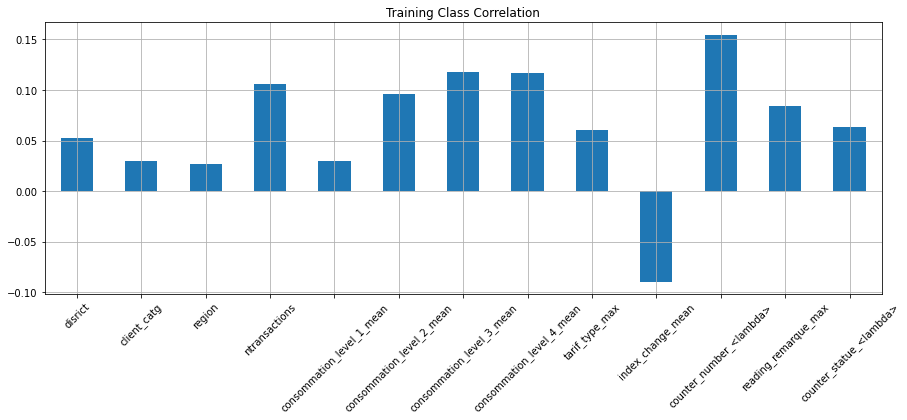

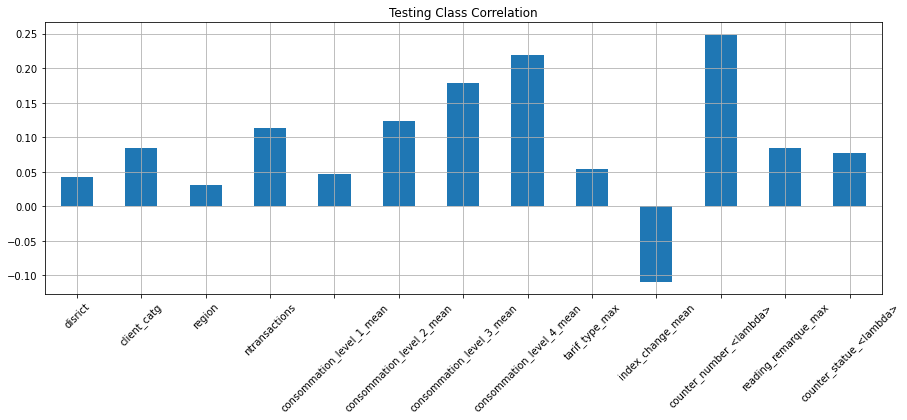

In [12]:
proba = torch_nn(X.astype(np.float32), y.astype(np.float32), X_pred.astype(np.float32)) 

proba[proba<=0.20] = 0.0
proba[proba>0.20] = 1.0
predictions = pd.DataFrame(proba)

L, F = predictions[0].value_counts()
print('Number of Fraudless CLients: ', L, ' Or ', round(L/(L+F)*100,1), '% of the data')
print('Number of Fraud Clients: ', F, ' Or ', round(F/(L+F)*100,1), '% of the data')

X_df.corrwith(train_clients.target, method='kendall').plot.bar(
        figsize=(15, 5), title="Training Class Correlation", fontsize=10,
        rot=45, grid=True)
plt.show()

X_pred_df.corrwith(predictions[0], method='kendall').plot.bar(
        figsize=(15, 5), title="Testing Class Correlation", fontsize=10,
        rot=45, grid=True)
plt.show()

The pytorch nn-module looks much better with closer matching correlations to the training data that indicate a more accurate fit. This is also cooberated by the fact that the percentage of fraud for the testing data is 4.7% which is within the expected range accounting for false postives and false negatives

This data can now be written to an output datasheet for the client to further persue action

In [43]:
results = pd.DataFrame({"client_id": test_clients["client_id"], "target": predictions[0]})
results.to_csv('submission.csv', index=False)